#### Small Dae Example

Ipopt 3.9.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Common Public License (CPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.9.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:       45
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        7

Total number of variables............................:       14
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
   

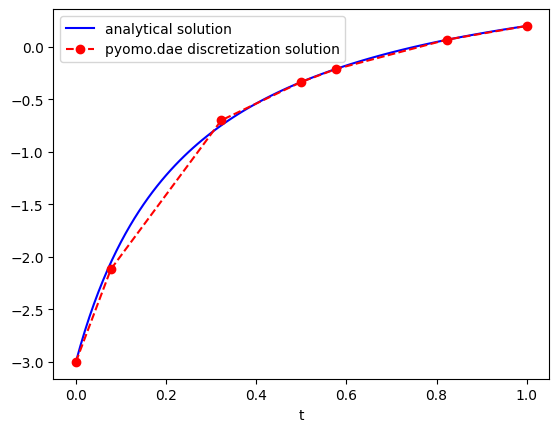

In [1]:
import pyomo.environ as pyo
from pyomo.dae import DerivativeVar, ContinuousSet

model = m = pyo.ConcreteModel()

m.t = ContinuousSet(bounds=(0,1))

m.z = pyo.Var(m.t)
m.dzdt = DerivativeVar(m.z)

m.obj = pyo.Objective(expr=1) # Dummy Objective

def _zdot(m, i):
    return m.dzdt[i] == m.z[i]**2 - 2*m.z[i] +1
m.zdot = pyo.Constraint(m.t,rule=_zdot)

def _init_con(m):
    return m.z[0] == -3
m.init_con = pyo.Constraint(rule=_init_con)

# Discretize using backward finite difference
#discretizer = pyo.TransformationFactory('dae.finite_difference')
#discretizer.apply_to(m, nfe=50, scheme='BACKWARD')

# Discretize using collocation
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(m, nfe=2, ncp=3 , scheme='LAGRANGE-RADAU')

solver = pyo.SolverFactory('ipopt')
solver.solve(m,tee=True)

import matplotlib.pyplot as plt

analytical_t = [0.01*i for i in range(0,101)]
analytical_z = [(4*t-3)/(4*t+1) for t in analytical_t]

findiff_t = list(m.t)
findiff_z = [pyo.value(m.z[i]) for i in m.t]

plt.plot(analytical_t,analytical_z,'b',label='analytical solution')
plt.plot(findiff_t,findiff_z,'ro--',label='pyomo.dae discretization solution')
plt.legend(loc='best')
plt.xlabel('t')
plt.show()
